In [1]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [00:19<00:00, 127MB/s]


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


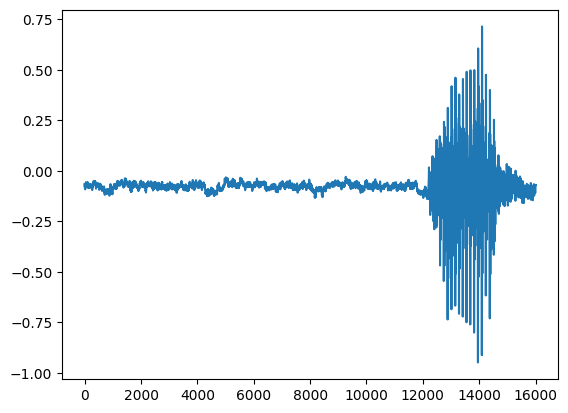

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [10]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [6]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [7]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [8]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [13]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [15]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [16]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [17]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.0026666666666666666/2 [00:02<26:46, 804.12s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.872374


  3%|▎         | 0.05599999999999999/2 [00:20<11:51, 365.89s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.290860


  5%|▌         | 0.10933333333333328/2 [00:36<09:37, 305.35s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.674699


  8%|▊         | 0.16266666666666676/2 [00:53<09:05, 297.15s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.576233


 11%|█         | 0.21600000000000033/2 [01:10<09:32, 320.70s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.280477


 13%|█▎        | 0.2693333333333337/2 [01:27<08:38, 299.43s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.985415


 16%|█▌        | 0.3226666666666667/2 [01:45<10:19, 369.10s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 2.068930


 19%|█▉        | 0.3759999999999997/2 [02:02<08:06, 299.47s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.707314


 21%|██▏       | 0.42933333333333273/2 [02:19<09:09, 349.72s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.604468


 24%|██▍       | 0.48266666666666574/2 [02:36<07:47, 308.25s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.657630


 27%|██▋       | 0.5359999999999995/2 [02:52<07:17, 298.68s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.514706


 29%|██▉       | 0.5893333333333336/2 [03:10<07:51, 334.06s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.621852


 32%|███▏      | 0.6426666666666677/2 [03:26<06:49, 301.73s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.359542


 35%|███▍      | 0.6960000000000018/2 [03:43<07:48, 359.10s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.289588


 37%|███▋      | 0.749333333333336/2 [04:00<06:24, 307.63s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.309621


 40%|████      | 0.8026666666666701/2 [04:17<06:01, 301.75s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.243109


 43%|████▎     | 0.8560000000000042/2 [04:34<06:13, 326.67s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.240553


 50%|█████     | 1.0000000000000062/2 [05:19<05:31, 331.80s/it]


Test Epoch: 1	Accuracy: 6594/11005 (60%)



 50%|█████     | 1.0026666666666728/2 [05:20<06:10, 371.64s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.171701


 53%|█████▎    | 1.0560000000000047/2 [05:38<04:53, 310.72s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.231954


 55%|█████▌    | 1.1093333333333366/2 [05:54<04:25, 298.41s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.095638


 58%|█████▊    | 1.1626666666666685/2 [06:11<04:30, 322.69s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.117565


 61%|██████    | 1.2160000000000004/2 [06:28<03:54, 299.22s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.116637


 63%|██████▎   | 1.2693333333333323/2 [06:45<04:27, 365.77s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.216725


 66%|██████▌   | 1.3226666666666642/2 [07:02<03:26, 305.56s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.884963


 69%|██████▉   | 1.3759999999999961/2 [07:18<03:06, 298.63s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.854661


 71%|███████▏  | 1.429333333333328/2 [07:36<03:03, 320.82s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 1.051659


 74%|███████▍  | 1.48266666666666/2 [07:52<02:35, 301.13s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.796154


 77%|███████▋  | 1.5359999999999918/2 [08:10<02:41, 347.83s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.849794


 79%|███████▉  | 1.5893333333333237/2 [08:27<02:05, 305.43s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.983044


 82%|████████▏ | 1.6426666666666556/2 [08:43<01:46, 299.33s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.856108


 85%|████████▍ | 1.6959999999999875/2 [09:01<01:35, 312.77s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.908537


 87%|████████▋ | 1.7493333333333194/2 [09:17<01:14, 297.92s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.785100


 90%|█████████ | 1.8026666666666513/2 [09:35<01:08, 348.58s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.989042


 93%|█████████▎| 1.8559999999999832/2 [09:52<00:45, 315.91s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.796598


100%|█████████▉| 1.9999999999999793/2 [10:37<00:00, 318.73s/it]


Test Epoch: 2	Accuracy: 7905/11005 (72%)



In [23]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[100]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: backward. Predicted: backward.


In [24]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: one.


In [25]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

ModuleNotFoundError: No module named 'pydub'